In [0]:
#必要なパッケージのインポート
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# 以下，混合ポアソン分布モデルでのギブスサンプリングの例

(array([37., 48., 21., 18., 20., 21., 26.,  7.,  1.,  1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

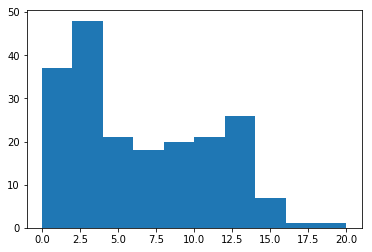

In [13]:
# データの生成
np.random.seed(seed=1)
n = 200 #サンプルサイズ
#真の分布を平均5のポアソン分布と平均7のポアソン分布の1:1の混合分布とする
data1 = np.random.poisson(2,n//2)
data2 = np.random.poisson(10,n//2)
data = np.concatenate([data1,data2])
plt.hist(data)

In [0]:
# 制御変数
H = 2 #コンポーネント数（今回はtrueと同じ2で固定）
K = 500 #サンプリング数
thin = 20 #サンプリング周期
burnin = 5000 #初期値の影響を切り捨てるバーンイン
iters = burnin + thin*K #実際の繰り返し回数
# ハイパーパラメータ：簡単のため・クリティカルな影響を避けるために事前分布が正かつ有界になるように設定
a = 1 #コンポーネント共通のハイパラ
b = 1 #コンポーネント共通のハイパラ
phi = 1 #混合比の事前分布はディリクレ分布のなかでも一様分布になるとき


## モデリング


* モデル
$$p(x|w) = \sum_{k=1}^H\pi_k\mathrm{Poi}(x|\lambda_1) =\sum_{k=1}^H\pi_k\frac{\lambda_1^x}{x!}\exp(-\lambda_1)$$

* 事前分布
$$\varphi_1(\lambda) = \prod_{k=1}^H\mathrm{Gam}(\lambda_k|a=1,b=1)
\propto \exp\left(-\sum_{k=1}^K \lambda_k\right),$$
$$\varphi_2(\pi) = \mathrm{Dir}(\pi|\phi=10)\propto \prod_{k=1}^H \pi_k^{\phi-1},$$
$$\varphi(\lambda,\pi)=\varphi_1(\lambda)\varphi_2(\pi) \propto  \exp\left(-\sum_{k=1}^K \lambda_k\right)\prod_{k=1}^H \pi_k^{\phi-1}.$$

隠れ変数$s \in \{(1,\ldots,0),\ldots,(0,\ldots,1)\}$を導入すると，

$$p(x,s|w)=\prod_{k=1}^H \pi_k^{s_k} \left( \frac{\lambda_1^x}{x!}\exp(-\lambda_1) \right)^{s_k}$$
$$s=(s_k)_{k=1}^H$$
となる．


以下では，$s$, $\lambda$, $\pi$をそれぞれギブスサンプリングによって得る．

## 簡易版　混合ポアソン分布のギブスサンプリングの概説

### 何を求めるアルゴリズムなの？

ギブスサンプリングでは、条件付き事後分布のパラメータを更新していく。条件付き事後分布のパラメータというのは、例えば隠れ変数とコンポーネントの平均パラメータが与えられたときの混合比の分布
$$\psi_3(\pi|s,\lambda) = \mathrm{Dir}(\pi | \hat{\phi})$$
の$\hat{\phi}$である。「事後分布はパラメータの分布」といった場合の、すなわちモデルのパラメータ$w$との混同を避けるために、分布パラメータと呼ぶ。分布パラメータの更新を行うが、混合比の分布が隠れ変数$s$やコンポーネントの平均$\lambda$に条件付けられているため、サンプリングによってこれらを獲得する。

次の次のコードブロックで、1回の計算で行われる各ステップを実装しているが、初期値か前のイテレーションにおけるサンプリング結果を用いており、またそれらに依存する形で分布パラメータが更新されている。

ギブスサンプリングはこの分布パラメータを更新しながらパラメータのサンプリングを行うことで、事後分布に従うパラメータを求めるアルゴリズムである。

### 各ステップのサンプリング

ギブスサンプリングの強みは、簡単な分布からの乱数生成を繰り返すのみで良いところにある。逆に、ギブスサンプリングを導出するためには、そのような事前分布設計が必要になる。事前分布は共役事前分布に触発されたものが用いられており、実際
$$隠れ変数 s \leftrightarrow 混合比 \pi$$
$$データ x \leftrightarrow コンポーネントの平均パラメータ \lambda$$
が成り立つことから条件付き事後分布を簡単な分布で書くことができる。

実際のサンプリングにあたっては、科学技術計算ライブラリに実装されている擬似乱数を使えばよい。本Notebookでは`numpy.random`を用いる。

In [0]:
#ポアソン分布の確率質量函数（離散的な分布の密度函数）
def poisson_pmf(x,w):
  rv = scipy.stats.poisson(w)
  return rv.pmf(x)

#ハイパーパラメータ
a = 1
b = 1
phi = 1
#パラメータの初期値
init_lam = np.array([2.0,10.0])
init_pi = np.array([0.5,0.5])
lam = init_lam
pi = init_pi
#サンプリング結果の保存先
all_lams = np.zeros([iters,H])
lams = np.zeros([K,H])
all_pis = np.zeros([iters,H])
pis = np.zeros([K,H])


In [0]:
#GSの各ステップを函数化
def latent_var_step(data,lam,pi):
  tmp = np.outer(data, np.log(lam)) - lam + np.log(pi)
  tmp = np.exp(tmp)
  eta = tmp.T / np.sum(tmp,axis=1).T
  eta = eta.T
  S = np.array([np.random.multinomial(n=1, pvals=eta[i,0:H]) for i in range(n)])
  return S

def lambda_step(data,S,a,b):
  hat_a = np.dot(data,S) + a
  hat_b = np.sum(S,axis=0) + b
  lam = np.random.gamma(shape=hat_a,scale=1.0/hat_b)
  return lam

def pi_step(data,S,phi):
  hat_phi = np.sum(S,axis=0) + phi
  pi = np.random.dirichlet(alpha=hat_phi)
  return pi

In [0]:
#MCMC
np.random.seed(seed=100)
##サンプリング
for iter in range(iters):
  S = latent_var_step(data,lam,pi)
  lam = lambda_step(data,S,a,b)
  all_lams[iter] = lam
  pi = pi_step(data,S,phi)
  all_pis[iter] = pi

##バーンインとシニング
for i in range(K):
  lams[i] = all_lams[burnin + thin*i]
  pis[i] = all_pis[burnin + thin*i]

#事後分布を書けと言われたらall_wsではなくwsのヒストグラムになることに注意！


([array([  7.,  17.,  72., 120., 122.,  85.,  45.,  25.,   5.,   2.]),
  array([  2.,   5.,  25.,  45.,  85., 122., 120.,  72.,  17.,   7.])],
 array([0.38014052, 0.40411242, 0.42808431, 0.45205621, 0.4760281 ,
        0.5       , 0.5239719 , 0.54794379, 0.57191569, 0.59588758,
        0.61985948]),
 <a list of 2 Lists of Patches objects>)

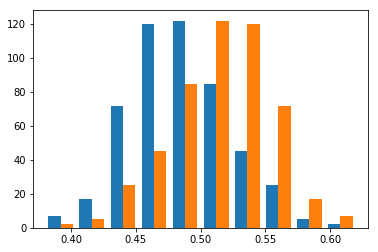

In [18]:
#混合比のヒストグラム
plt.hist(pis)

([array([494.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,  14., 387.,  99.])],
 array([ 1.34519959,  2.31206394,  3.27892828,  4.24579262,  5.21265697,
         6.17952131,  7.14638566,  8.11325   ,  9.08011435, 10.04697869,
        11.01384304]),
 <a list of 2 Lists of Patches objects>)

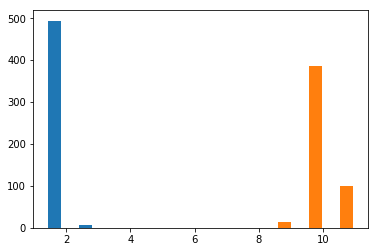

In [19]:
#コンポーネントの平均値のヒストグラム
plt.hist(lams)

### 予測分布

予測分布の理論式は
$$p^*(x) = \int p(x|w)\psi(w|X^n)dw$$
であった．これは$p(x|w)$の事後分布$\psi(w|X^n)$平均そのものである．

従って，MCMCの結果を使うと
$$p^*(x) = \int p(x|w)\psi(w|X^n)dw \approx \frac{1}{K}\sum_{k=1}^K p(x|w_k)$$
となる．ここで，$(w_1,\ldots,w_K)$はMCMCのサンプリング結果．

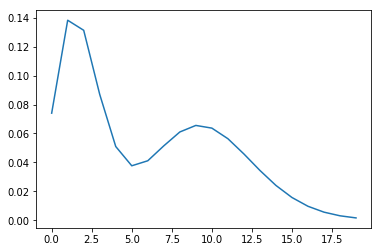

In [20]:
#予測分布の計算
plot_x = np.linspace(0,19,20)

predict =np.array([
    np.mean(np.array([pis[k,0]*poisson_pmf(x,lams[k,0])
                      + pis[k,1]*poisson_pmf(x,lams[k,1]) for k in range(K)]
                    ))
    for x in plot_x
])
plt.plot(plot_x,predict)